## 1. Import libraries

In [1]:
import pickle
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('classic')

## 2. Constitutive model

The first example concerns an incrementally nonlinear elasto-plastic, non-associative, Drucker-Prager material, with constant density. The specific internal energy is defined as

\begin{equation}
\widehat{u}(\boldsymbol{\varepsilon^e}) = \dfrac{1}{2}K{\varepsilon_v^e}^2+\dfrac{3}{2}G{\varepsilon^e_s}^2,
\end{equation}

where $\varepsilon_v^e=\boldsymbol{1}: \boldsymbol{\varepsilon}^e$ is the volumetric invariant of the strain tensor and ${\varepsilon_s^e = \sqrt{\frac{2}{3}\;{\boldsymbol{\varepsilon}^e}^{\prime}\hspace{-3pt}:{\boldsymbol{\varepsilon}^e}^{\prime}}}$ is the invariant of the deviatoric strain tensor,  where ${\boldsymbol{\varepsilon}^e}^{\prime} = \boldsymbol{\varepsilon}^e-\frac{\varepsilon^e_v}{3}\boldsymbol{1}$. We select $K=70$ GPa, $G=60$ GPa, friction coefficient equal to one, seismic parameter equal to one, and dilatancy parameter equal to one half.

For more details, see:

I Einav. The unification of hypo-plastic and elasto-plastic theories. *International Journal of Solids and Structures*, 49(11-12):1305–1315, 2012. doi: 10.1016/j.ijsolstr.2012.02.003.).


### 2.1 Define constitutive and evolution equations

In [2]:
def elastic_energy(eev, ees):
    return 0.5*K*eev**2+3/2*G*ees**2

def Stress(eev, ees):
    p = K*eev
    q = 3*G*ees
    return p,q

def find_strain(e, sigma):
    eev,ees = e[0],e[1]
    p,q = Stress(eev, ees)
    return np.hstack((p-sigma[0],q-sigma[1]))

def macaulay(x):
    if x<0: return 0.
    else: return x

### 2.2 Define initial value problem for strain- and stress-driven loading path

In [3]:
def evol_state(t,statet,dot_e):
    ''' Strain-controlled loading path '''
    ee = statet[:2]
    ep = statet[2:4]
    st = statet[4:6]
    p = K*ee[0]
    q = 3*G*ee[1]
        
    if statet[-1]<0.: dot_e[1]=0.
    if statet[-2]<0.: dot_e[0]=0.
    dot_ev,dot_es = dot_e[0],dot_e[1]

    dot_eps_st = (dot_es-m*K/(3*G)*dot_ev)/(1+b*K/(3*G))
    
    dot_epv = -b*(q/(m*p))**(s+1)*macaulay(dot_eps_st)
    dot_eps = (q/(m*p))**(s)*macaulay(dot_eps_st)

    
    dot_eev = dot_ev-dot_epv
    dot_ees = dot_es-dot_eps
    dot_p = K*dot_eev
    dot_q = 3*G*dot_ees
    return np.hstack((np.hstack((dot_eev,dot_ees)),
                      np.hstack((dot_epv,dot_eps)),
                      np.hstack((dot_p,dot_q)),
                      dot_e))
    
def evol_state_stress(t,statet,dot,c):
    ''' Stress-controlled loading path '''
    ee = statet[:2]
    ep = statet[2:4]
    st = statet[4:6]
    p = K*ee[0]
    q = 3*G*ee[1]
    dot_e3 = fsolve(fsolve_evol_state, args=(dot[0],statet,c),x0=[dot[0]/10])
    dot_ev = dot[0]+2*dot_e3
    dot_es = (np.sqrt(2/3)*(dot[0]-dot_e3))
    dot_e = np.hstack((dot_ev,dot_es))
    
    dot_eps_st = (dot_es-m*K/(3*G)*dot_ev)/(1+b*K/(3*G))
    
    dot_epv = -b*(q/(m*p))**(s+1)*macaulay(dot_eps_st)
    dot_eps = (q/(m*p))**(s)*macaulay(dot_eps_st)

    
    dot_eev = dot_ev-dot_epv
    dot_ees = dot_es-dot_eps
    dot_p = K*dot_eev
    dot_q = 3*G*dot_ees

    return np.hstack((np.hstack((dot_eev,dot_ees)),
                      np.hstack((dot_epv,dot_eps)),
                      np.hstack((dot_p,(dot_q))),
                      dot_e))

def fsolve_evol_state(dot_e3,dot_e1_target,statet,c):
    ''' Find strain-increments to satisfy stress-controlled loading path '''
    ee = statet[:2]
    ep = statet[2:4]
    st = statet[4:6]
    p = K*ee[0]
    q = 3*G*ee[1]
    
    dot_ev = dot_e1_target+2*dot_e3
    dot_es = np.sqrt(2/3)*(dot_e1_target-dot_e3)
    
    dot_eps_st = (dot_es-m*K/(3*G)*dot_ev)/(1+b*K/(3*G))
    
    dot_epv = -b*(q/(m*p))**(s+1)*macaulay(dot_eps_st)
    dot_eps = (q/(m*p))**(s)*macaulay(dot_eps_st)

    
    dot_eev = dot_ev-dot_epv
    dot_ees = dot_es-dot_eps
    dot_p = K*dot_eev
    dot_q = 3*G*dot_ees
    return np.abs(dot_p-c*dot_q)

### 2.3 Solution of the initial value problem

In [4]:
def solve(state_t,deps,dt):
    ''' Strain-controlled IVP '''
    eps_dot = deps/dt
    sol = solve_ivp(evol_state,
                args=[eps_dot],
                    t_span=[0.,dt],
                    t_eval=[dt],
                    y0=state_t,
                    vectorized=False,
                    atol = 1.e-6,
                    rtol = 1e-5,
                    method='RK45')
    sol = sol.y[:,-1]
    return sol

def solve_stress(state_t,dsigma,dt,c):
    ''' Stress-controlled IVP '''
    sigma_dot = dsigma/dt
    sol = solve_ivp(evol_state_stress,
                args=[sigma_dot,c],
                    t_span=[0.,dt],
                    t_eval=[dt],
                    y0=state_t,
                    vectorized=False,
                    atol = 1.e-8,
                    rtol = 1e-7,
                    method='RK23')
    sol = sol.y[:,-1]
    return sol

### 2.4 Material parameters

In [5]:
K = 70.e+6
G = 60.e+6
m = 1.
b = 0.5*m
s = 1

## 3. Loading paths

We generate data by applying single loading-unloading paths, with constant strain rate, and integrating in time the evolution equation for the elastic strain rate (using Eq. (8.15) in Einav, 2012) to compute the evolution of stress according to the energy function. The material stress is here identified in terms of its volumetric and deviatoric parts:

$p=\boldsymbol{1}:\frac{\boldsymbol{\sigma}}{3}$ and $\smash{q = \sqrt{{\frac{3}{2}}\;\boldsymbol{\sigma}^{\prime}\hspace{-3pt}:\boldsymbol{\sigma}^{\prime}}}$, with $\boldsymbol{\sigma}^{\prime} = \boldsymbol{\sigma}-p\boldsymbol{1}$.

From an initial unstressed configuration, the material is first subjected to isotropic compression to generate states at different confining pressures, $p\in [200, 2200]$ kPa. This then represents the initial configuration for subsequent numerical experiments composed of the following loading paths: isotropic compression/extension, undrained compression, and drained triaxial compression/extension. Each path is composed of $N=40$ measurements of the stress values.

### 3.1 Drained triaxial

- $c=0$ at constrant pressure
- $c=1/3$ compression
- $c=-1/3$ extension

In [6]:
# Control variable
c = 0

pp = np.arange(200,2500,400) # confining pressure values
N = pp.shape[0]

n_reset = 40 # number of increments before resetting
increments = N*n_reset # number of increments
d=1

mod= 10e-7
id_de = 0
subincrements = 20
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,2))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1.,1]),sub)
delta = np.zeros((increments,2))
for i in np.arange(0,increments//subincrements,1):
    k = i*subincrements
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]
        
dt=1.0
state_t = np.zeros((increments+1,8))
state_rst = np.zeros((N,8))

sub = 30
for i in range(increments):
    if not i % n_reset:
        delta[i:i+sub,0]=np.abs(delta[i:i+sub,0])
        delta[i+sub:,0]=-np.abs(delta[i+sub:,0])
        p_0 = pp[i//n_reset]
        q_0 = 0.
        e_0 = fsolve(find_strain, args=(np.hstack((p_0,q_0))),x0=np.zeros((2)))
        state_t0 = np.hstack((e_0,np.zeros((2)),np.hstack((p_0,q_0)),e_0))
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()
    
    state_t_ = solve_stress(state_t,delta[i],dt,c)
    if state_t_[-3]<0.0:
        delta[i:i+subincrements-i%subincrements,0]=0*np.abs(delta[i:i+subincrements-i%subincrements,0])
        state_t_ = solve_stress(state_t,delta[i],dt,c)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

/home/fil/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


### 3.2 Isotropic compression-extension

In [7]:
pp = np.arange(200,2500,400) # confining pressure values
N = pp.shape[0]

n_reset = 40 # number of increments before resetting
increments = N*n_reset # number of increments
d=1

mod= 10e-7
id_de = 0
subincrements = 20
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,2))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1,1]),sub)
delta = np.zeros((increments,2))
for i in np.arange(0,increments//subincrements,1):
    k = i*subincrements
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]
dt=1.0
state_t = np.zeros((increments+1,8))
state_rst = np.zeros((N,8))

sub = 30
for i in range(increments):
    if not i % n_reset:
        delta[i:i+sub]=np.abs(delta[i:i+sub])
        delta[i+sub:]=-np.abs(delta[i+sub:])
        p_0 = pp[i//n_reset]
        q_0 = 0.
        e_0 = fsolve(find_strain, args=(np.hstack((p_0,q_0))),x0=np.zeros((2)))
        state_t0 = np.hstack((e_0,np.zeros((2)),np.hstack((p_0,q_0)),e_0))
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()

    state_t_ = solve(state_t,delta[i],dt)
    if state_t_[-4]<0.0:
        delta[i:i+subincrements-i%subincrements,0]=0*np.abs(delta[i:i+subincrements-i%subincrements,0])
        state_t_ = solve(state_t,delta[i],dt)        
    if state_t_[-4]>3000.0:
        delta[i:i+subincrements-i%subincrements,0]=-np.abs(delta[i:i+subincrements-i%subincrements,0])
        state_t_ = solve(state_t,delta[i],dt)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

### 3.3 Undrained triaxial compression-extension

In [8]:
pp = np.arange(200,2500,400) # confining pressure values
N = pp.shape[0]
n_reset = 40 # number of increments before resetting
increments = N*n_reset # number of increments
d=1


mod= 10e-7
id_de = 1
subincrements = 20
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,2))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1,1]),sub)
delta = np.zeros((increments,2))
for i in np.arange(0,increments//subincrements,1):
    if not i%2:
        deps_inc_sub[i] = np.abs(deps_inc_sub[i])
    else:
        deps_inc_sub[i] = -np.abs(deps_inc_sub[i])
    k = i*subincrements
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]
        
dt=1.0
state_t = np.zeros((increments+1,8))
state_rst = np.zeros((N,8))

sub = 25
for i in range(increments):
    if not i % n_reset:
        delta[i:i+sub]=np.abs(delta[i:i+sub])
        delta[i+sub:]=-np.abs(delta[i+sub:])
        p_0 = pp[i//n_reset]
        q_0 = 0.
        e_0 = fsolve(find_strain, args=(np.hstack((p_0,q_0))),x0=np.zeros((2)))
        state_t0 = np.hstack((e_0,np.zeros((2)),np.hstack((p_0,q_0)),e_0))
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()

    state_t_ = solve(state_t,delta[i],dt)
    if state_t_[-3]<0.0:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ = solve(state_t,delta[i],dt)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

## 4. Define and store state evolution

In [9]:
svars_t=np.array([state_t_hist[i-1] for i in range(0,increments)])
for i in np.arange(0,len(svars_t),n_reset):
    svars_t[i]= state_rst[i//n_reset]

In [10]:
eev_tdt,ees_tdt = state_t_hist[:,0],state_t_hist[:,1]
epv_tdt,eps_tdt = state_t_hist[:,2],state_t_hist[:,3]
p_tdt,q_tdt = state_t_hist[:,4],state_t_hist[:,5]
ev_tdt,es_tdt = state_t_hist[:,6],state_t_hist[:,7]

eev_t,ees_t = svars_t[:,0],svars_t[:,1]
epv_t,eps_t = svars_t[:,2],svars_t[:,3]
p_t,q_t = svars_t[:,4],svars_t[:,5]
ev_t,es_t = svars_t[:,6],svars_t[:,7]

In [11]:
dev,des = ev_tdt-ev_t,es_tdt-es_t
depv,deps = epv_tdt-epv_t,eps_tdt-eps_t

dev /=dt
des /=dt
depv /=dt
deps /=dt

In [12]:
en_t = elastic_energy(eev_t,ees_t)
en_tdt = elastic_energy(eev_tdt,ees_tdt)

stress_t = np.vstack((p_t,q_t)).T
strain_t = np.vstack((ev_t,es_t)).T
svars_p_t = np.vstack((epv_t,eps_t)).T
svars_e_t = np.vstack((eev_t,ees_t)).T

stress_tdt = np.vstack((p_tdt,q_tdt)).T
strain_tdt = np.vstack((ev_tdt,es_tdt)).T
svars_p_tdt = np.vstack((epv_tdt,eps_tdt)).T
svars_e_tdt = np.vstack((eev_tdt,ees_tdt)).T

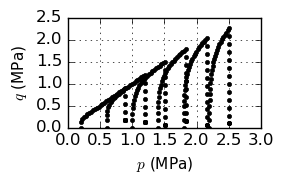

In [13]:
fig = plt.figure(dpi=100, figsize=(3,2.), tight_layout=True)
ax = fig.subplots(1)
ax.plot(p_t/1e+3,q_t/1e+3,'o',color='black',alpha=1,markersize=3,linewidth=0,linestyle='-',)
ax.set_ylabel('$q$ (MPa)',fontsize="11")
ax.set_xlabel('$p$ (MPa)',fontsize="11")
ax.grid()
ax.plot(0,0)
fig.patch.set_facecolor('white')

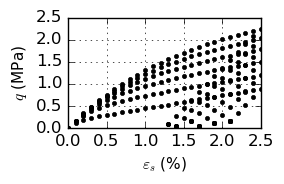

In [16]:
fig = plt.figure(dpi=100, figsize=(3,2), tight_layout=True)
ax = fig.subplots(1)
ax.plot(es_t*1e+5,q_t/1e+3,'o',color='black',alpha=1,markersize=3,linewidth=0,linestyle='-',)
ax.set_ylabel('$q$ (MPa)',fontsize="11")
ax.set_xlabel('$\\varepsilon_s$ (%)',fontsize="11")
ax.grid()
fig.patch.set_facecolor('white')

In [15]:
data = [stress_t,strain_t,svars_e_t,svars_p_t,
        stress_tdt,strain_tdt,svars_e_tdt,svars_p_tdt,en_tdt,dt,n_reset]
with open('./MAT1_loading_path', 'wb') as f_obj:
     pickle.dump(data, f_obj)